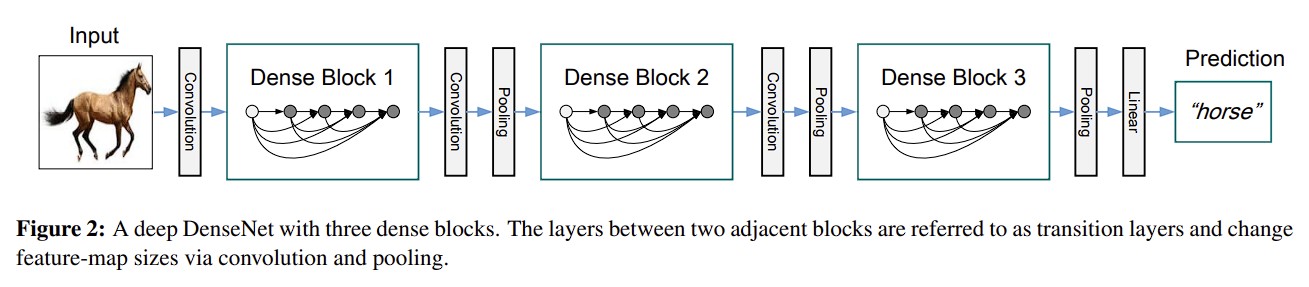

In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

In [3]:
class Bottleneck_block(nn.Module):
    def __init__(self, in_planes, out_planes, drop_rate=0.0):
        super(Bottleneck_block, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1, 
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.DropRate = drop_rate

    def forward(self, x):
        output = self.conv1(self.relu(self.bn1(x)))
        if self.DropRate > 0.0:
            output = F.dropout(output, p=self.DropRate, training=self.training)
        output = self.conv2(self.relu(self.bn2(output)))
        if self.DropRate > 0.0:
            output = F.dropout(output, p=self.DropRate, training=self.training)
        return torch.cat([x, output], 1)

In [4]:
class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, drop_rate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, 
                               padding=0,bias=False)
        self.DropRate = drop_rate
    def forward(self, x):
        output = self.conv1(self.relu(self.bn1(x)))

        if self.DropRate > 0.0:
            output = F.dropout(output, p=self.DropRate, training=self.training)
        return F.avg_pool2d(output, 2)

In [5]:
class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, drop_rate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, drop_rate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, drop_rate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate,drop_rate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

In [6]:
import math
class DenseNet3(nn.Module):
    def __init__(self, depth, num_classes, growth_rate=12, reduction=0.5, drop_rate=0.0):
        super(DenseNet3, self).__init__()

        in_planes = 2 * growth_rate
        n = (depth - 4) / 3
        n = int(n/2)
        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.block1 = DenseBlock(n, in_planes, growth_rate, Bottleneck_block, drop_rate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans1 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), drop_rate)
        in_planes = int(math.floor(in_planes*reduction))

        self.block2 = DenseBlock(n, in_planes, growth_rate, Bottleneck_block, drop_rate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans2 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), drop_rate)
        in_planes = int(math.floor(in_planes*reduction))

        self.block3 = DenseBlock(n , in_planes, growth_rate, Bottleneck_block,drop_rate)
        in_planes = int(in_planes+n*growth_rate)

        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(in_planes, num_classes)
        self.in_planes = in_planes
        #weight initialization ig
        for m in self.modules():
            if isinstance(m, nn.Conv2d): # Kaiming Initialization
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        output = self.conv1(x)
        output = self.trans1(self.block1(output))
        output = self.trans2(self.block2(output))
        output = self.block3(output)
        output = self.relu(output)
        output = F.avg_pool2d(output, 8)
        output = output.view(-1, self.in_planes)
        return self.fc(output)

In [7]:
model = DenseNet3(depth=40, num_classes=10, growth_rate=12, reduction=0.5, drop_rate=0.2)

In [8]:
x = torch.randn(4, 3, 32, 32)  

In [9]:
output = model(x)
print("Output shape:", output.shape)

Output shape: torch.Size([4, 10])


In [ ]:
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [12]:
from torchvision.transforms import v2
train_transforms = v2.Compose([
    v2.RandomCrop(size=(32, 32)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

test_transforms = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

c:\Users\blade\anaconda3\envs\pytorch-gpu\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


100.0%


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified
